# Test to add an additional burn-in phase

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import corner
import density_contour
import emcee
import pickle
from astropy.coordinates import SkyCoord
from astropy import units as u
import time
import copy

%matplotlib inline

sys.path.append('../SF_history')
import sf_history
sys.path.append('../stats')
import stats
sys.path.append('../binary')
import binary_evolve
sys.path.append('../pop_synth')
import pop_synth
import load_sse



/Library/Python/2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [60]:
nwalkers=80

def run_emcee_2(M2_d, P_orb_obs, ecc_obs, ra, dec, M2_d_err=1.0,
    P_orb_obs_err=1.0, ecc_obs_err=0.05, nburn=1000, nsteps=1000):
    """ Run the emcee function

    Parameters
    ----------
    M2_d : float
        Observed secondary mass
    P_orb_obs : float
        Observed orbital period
    ecc_obs : float
        Observed orbital eccentricity
    ra : float
        Observed right ascension
    dec : float
        Observed declination

    Returns
    -------
    sampler : emcee object
    """

    # First thing is to load the sse data and SF_history data
    load_sse.load_sse()
    sf_history.load_sf_history()

    # Get initial values
    initial_vals = stats.get_initial_values(M2_d, nwalkers=nwalkers)

    # Define sampler
    args = [[M2_d, M2_d_err, P_orb_obs, P_orb_obs_err, ecc_obs, ecc_obs_err, ra, dec]]
    sampler = emcee.EnsembleSampler(nwalkers=nwalkers, dim=10, lnpostfn=stats.ln_posterior, args=args)

    # Assign initial values
    p0 = np.zeros((nwalkers,10))
    p0 = stats.set_walkers(initial_vals, args[0], nwalkers=nwalkers)

    # Burn-in 1
    pos,prob,state = sampler.run_mcmc(p0, N=nburn)
    sampler1 = copy.copy(sampler)
    
    
    
    # TESTING BEGIN - Get limiting ln_prob for worst 8 chains
    prob_lim = (np.sort(prob)[7] + np.sort(prob)[8])/2.0
    index_best = np.argmax(prob)
        
    for i in np.arange(len(prob)):
        if prob[i] < prob_lim:  pos[i] = np.copy(pos[index_best]) + np.random.normal(0.0, 0.005, size=10)
    # TESTING END
    
        
    # Burn-in 2
    sampler.reset()
    pos,prob,state = sampler.run_mcmc(pos, N=nburn)
    sampler2 = copy.copy(sampler)
    
    
    # TESTING BEGIN - Get limiting ln_prob for worst 8 chains
    prob_lim = (np.sort(prob)[7] + np.sort(prob)[8])/2.0
    index_best = np.argmax(prob)
        
    for i in np.arange(len(prob)):
        if prob[i] < prob_lim:  pos[i] = np.copy(pos[index_best]) + np.random.normal(0.0, 0.005, size=10)
    # TESTING END


    
    # Full run
    sampler.reset()
    pos,prob,state = sampler.run_mcmc(pos, N=nsteps)

    return sampler1, sampler2, sampler

In [83]:
M1 = 13.0
M2 = 10.0
A = 100.0
ecc = 0.3
v_k = 250.0
theta = 2.9
phi = 0.9
t_b = 22.0

# Now, run full evolution
M1_obs, M2_obs, L_x_obs, v_sys_obs, M2_dot_obs, A_obs, ecc_obs, theta_obs \
    = pop_synth.full_forward(M1,M2,A,ecc,v_k,theta,phi,t_b)

# Let's put some uncertainties on those observations
M2_d_err = 1.0
P_orb_obs_err = 1.0
ecc_obs_err = 0.05

# Now, define system observations
ra_obs = 13.5
dec_obs = -72.63
P_obs = binary_evolve.A_to_P(M1_obs, M2_obs, A_obs)

ra_b = 13.51
dec_b = -72.7

truths=[M1, M2, A, ecc, v_k, theta, phi, ra_b, dec_b, t_b]

In [88]:
x = M1, M2, A, ecc, v_k, theta, phi, ra_b, dec_b, t_b
y = ra_obs, dec_obs, M1, M2, A, ecc, v_k, theta, phi, ra_b, dec_b, t_b
args = M2_obs, M2_d_err, P_obs, P_orb_obs_err, ecc_obs, ecc_obs_err, ra_obs, dec_obs

prior_truths = stats.ln_priors(y)
posterior_truths = stats.ln_posterior(x, args)
print "Prior:", prior_truths
print "Posterior:", posterior_truths

Prior: -10.7914907032
Posterior: [-11.47082982]


In [74]:
# Record time
start_time = time.time()

# Run sampler
sampler1, sampler2, sampler3 = run_emcee_2(M2_obs, P_obs, ecc_obs, ra_obs, dec_obs, \
    M2_d_err=M2_d_err, P_orb_obs_err=P_orb_obs_err, ecc_obs_err=ecc_obs_err, \
    nburn=1000, nsteps=1000)

end_time = time.time()

print "Simulation took", end_time-start_time, "seconds"

Simulation took 8396.92261887 seconds


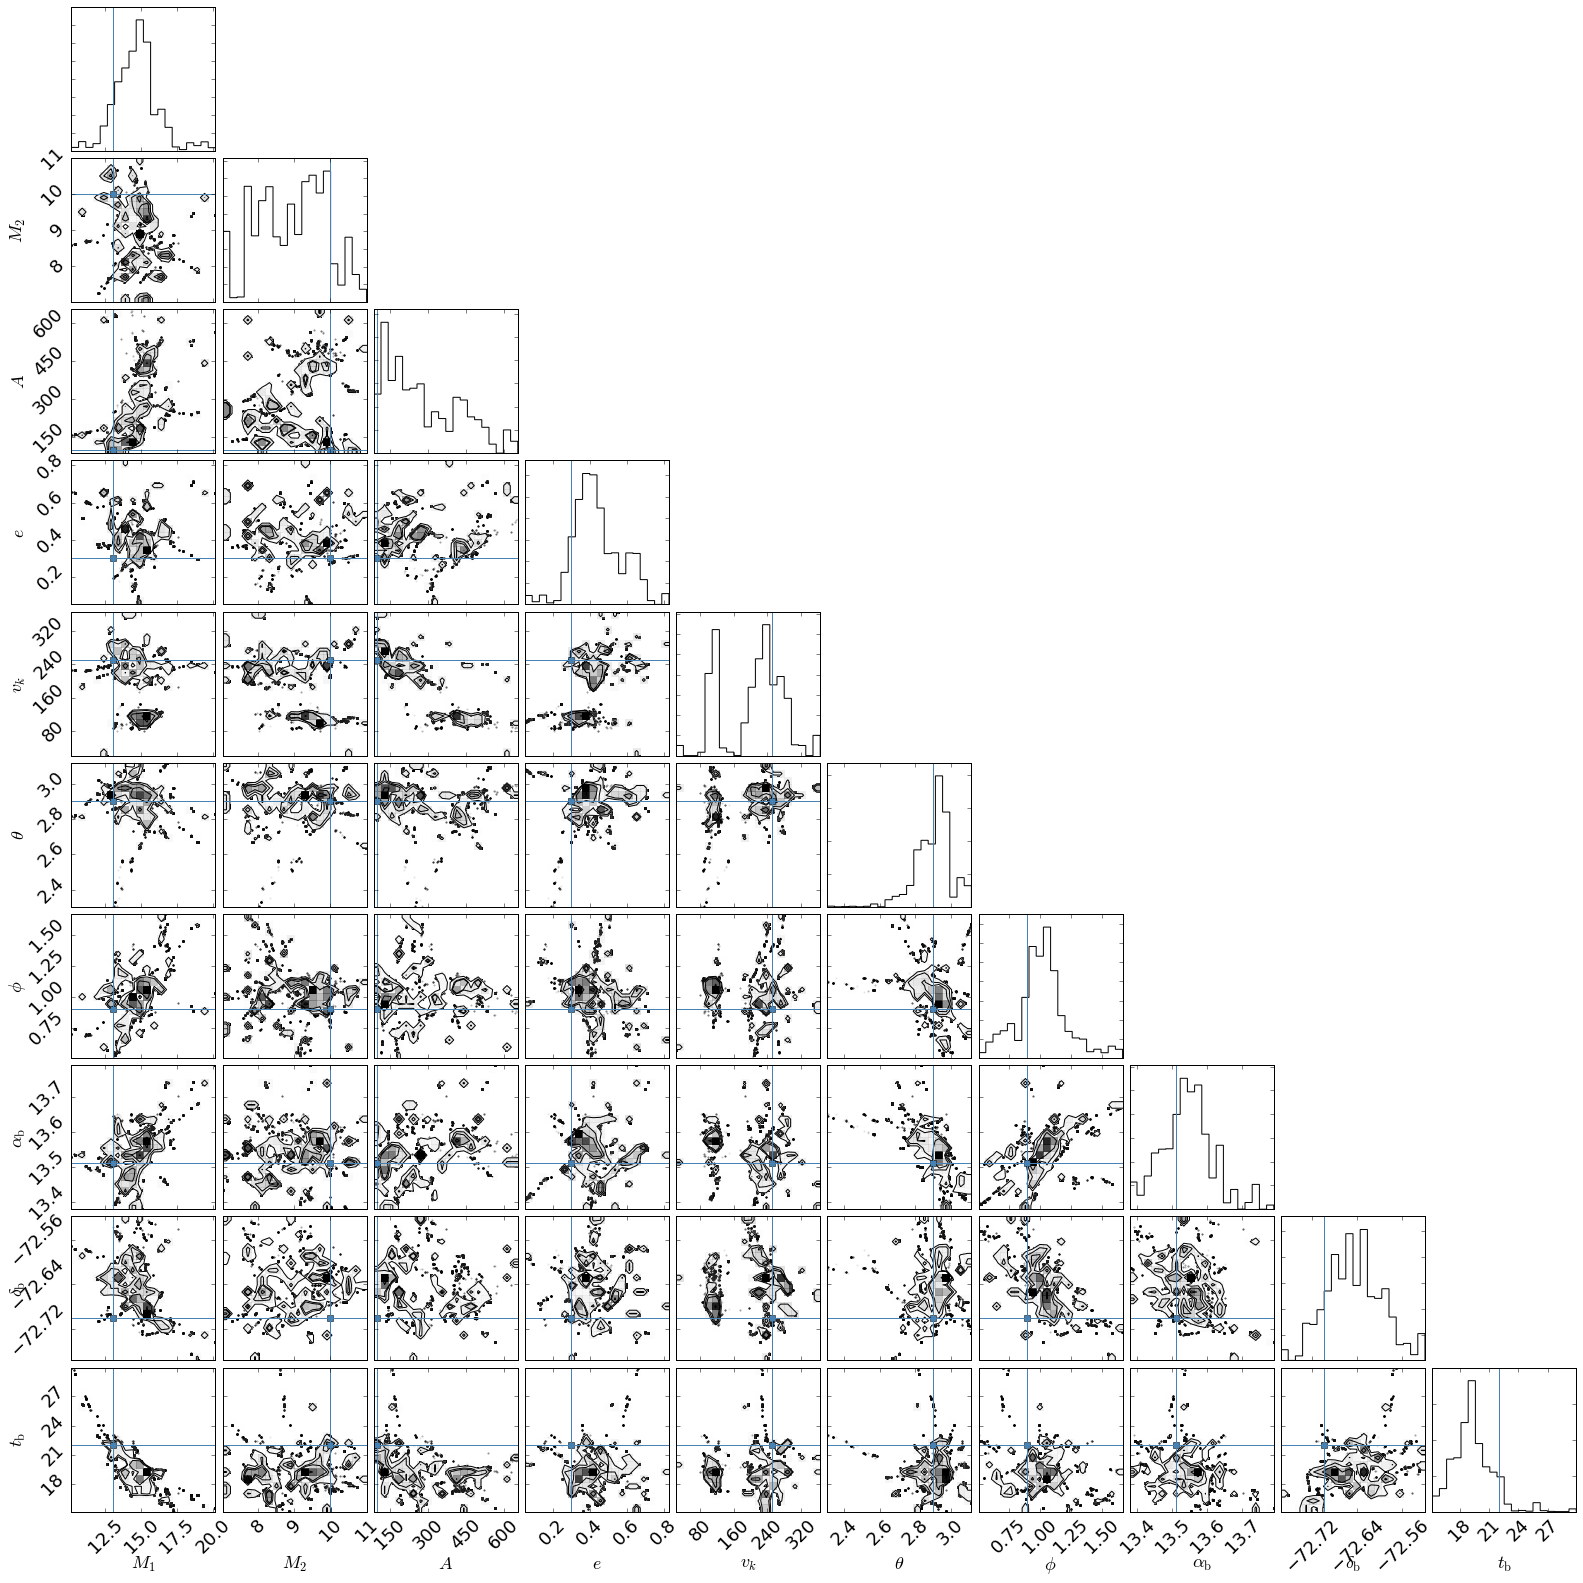

In [81]:
labels = [r"$M_1$", r"$M_2$", r"$A$", r"$e$", r"$v_k$", r"$\theta$", r"$\phi$", r"$\alpha_{\rm b}$", r"$\delta_{\rm b}$", r"$t_{\rm b}$"]
fig = corner.corner(sampler3.flatchain, labels=labels, truths=truths)
plt.rc('font', size=18)
plt.show()
plt.rc('font', size=10)

(80, 1000)
(80, 1000)
(2, 5)


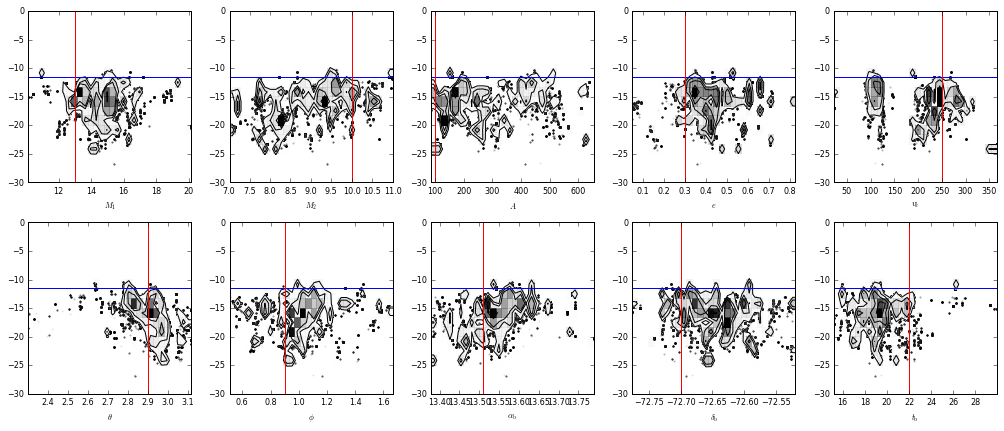

In [90]:
#corner.hist2d(sampler.flatchain.T[4], sampler.lnprobability)
plt.rc('font', size=8)
fig, ax = plt.subplots(2,5, figsize=(14,6))

print sampler3.chain[:,:,4].shape
print sampler3.lnprobability.shape

print ax.shape

for i in np.arange(10):
    a = np.int(i/5)
    b = i%5

    xmin = np.min(sampler3.chain[:,:,i])
    xmax = np.max(sampler3.chain[:,:,i])
    corner.hist2d(sampler3.chain[:,:,i], sampler3.lnprobability, ax=ax[a,b], bins=30, range=((xmin,xmax),(-50,0)))
    ax[a,b].set_xlabel(labels[i])
    
    ax[a,b].set_ylim(-30,0)
    ax[a,b].axhline(posterior_truths)
    ax[a,b].axvline(truths[i], color='r')
    
plt.tight_layout()

plt.show()

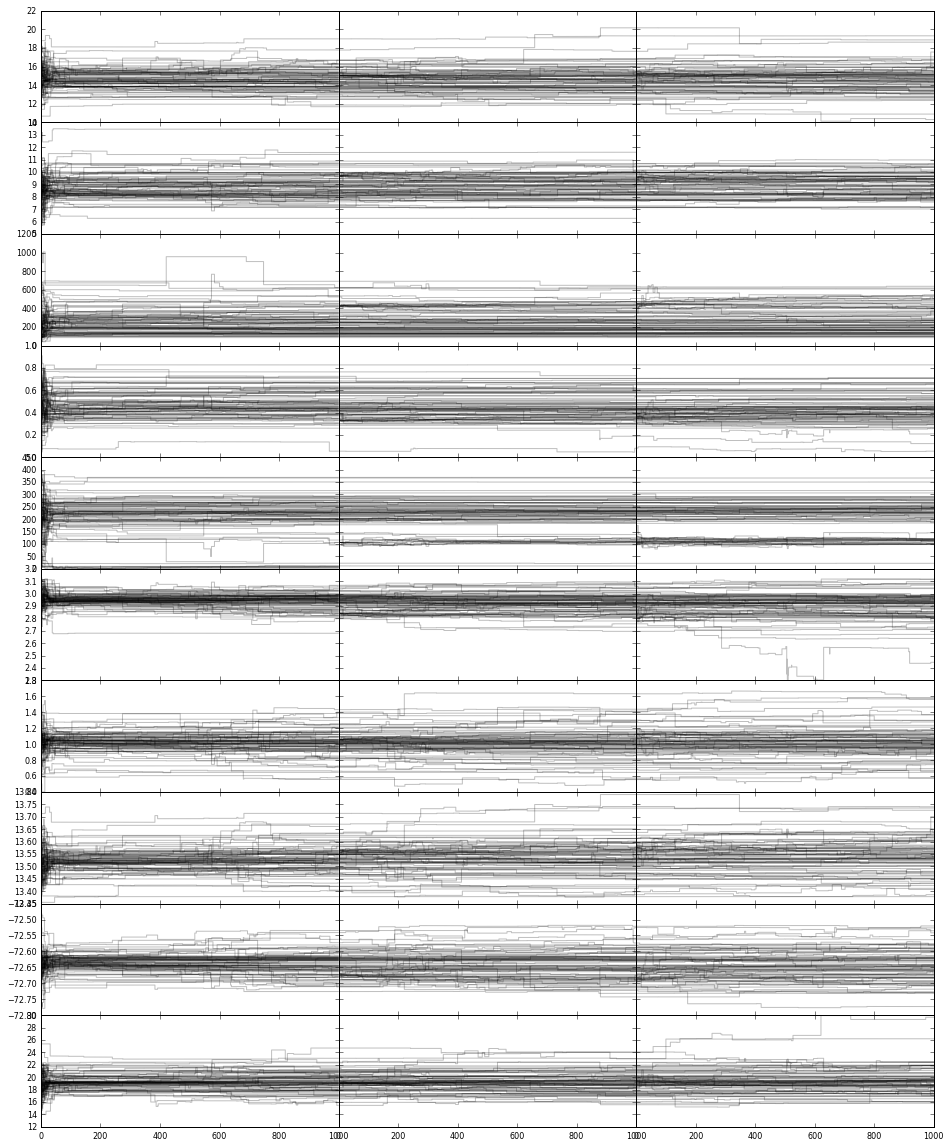

In [75]:
# Chains plot
fig, ax = plt.subplots(sampler1.dim, 3, sharex=True, figsize=(16.0,20.0))
for i in range(sampler1.dim):
    for j in np.arange(len(sampler1.chain[...])):

        chain1 = sampler1.chain[...,i][j]
        ax[i,0].plot(chain1, alpha=0.25, color='k', drawstyle='steps')

        chain2 = sampler2.chain[...,i][j]
        ax[i,1].plot(chain2, alpha=0.25, color='k', drawstyle='steps')

        chain3 = sampler3.chain[...,i][j]
        ax[i,2].plot(chain3, alpha=0.25, color='k', drawstyle='steps')

    # Remove tick labels from y-axis
    ax[i,1].set_yticklabels([])
    ax[i,2].set_yticklabels([])

    
# Make all plots have the same y-range - plots must already be created
for i in range(sampler1.dim):
    ymin = min(ax[i,0].get_ylim()[0],ax[i,1].get_ylim()[0],ax[i,2].get_ylim()[0])
    ymax = max(ax[i,0].get_ylim()[1],ax[i,1].get_ylim()[1],ax[i,2].get_ylim()[1])
    
    ax[i,0].set_ylim(ymin, ymax)
    ax[i,1].set_ylim(ymin, ymax)
    ax[i,2].set_ylim(ymin, ymax)
    
    
# Make plots touch
fig.subplots_adjust(hspace=0, wspace=0)

# Set tick size
plt.yticks(fontsize = 8)

plt.show()

In [76]:
print sampler3.acor

[ 59.15548894  78.43057479  69.59582008  90.65974911  85.25115593
  88.45809168  74.23858703  78.50991488  65.92132509  84.75735893]
